# Celebrity Face Generation with GANs

The purpose of this project is to design and implement a Generative Adversarial Network (GAN) using PyTorch, with a focus on generating synthetic face images that closely resemble real ones. GANs are powerful deep learning models that consist of a generator and a discriminator, trained iteratively to generate realistic data. In our case, the GAN will be trained on a curated dataset, the CelebFaces Attributes (CelebA), obtained from Kaggle.

## Dataset Overview
The CelebA dataset comprises more than 200,000 face images featuring various celebrities. Each image is associated with 40 binary attribute annotations, providing rich information about facial characteristics. This diverse dataset encompasses a wide range of facial poses, backgrounds, and individuals, making it an ideal resource for training and testing our GAN model.

## Data Preprocessing
The images from the CelebA dataset are preprocessed using PyTorch's ImageFolder and DataLoader modules. The preprocessing pipeline involves resizing, center cropping, and normalization to ensure consistent input dimensions and facilitate convergence during training. The dataset is then divided into batches, and a custom DeviceDataLoader is implemented to efficiently move the data to the available computing device (CPU or GPU).

## Model Architecture
The GAN architecture consists of two main components: the discriminator and the generator. The discriminator aims to distinguish between real and generated images, while the generator aims to create synthetic images that are indistinguishable from real ones.

## Discriminator:
The discriminator is implemented as a sequential neural network with convolutional layers, batch normalization, and leaky rectified linear unit (LeakyReLU) activations. It takes as input a 3-channel image and produces a binary output indicating the authenticity of the input.

## Generator:
The generator is designed to take random noise as input and generate realistic face images. It employs transpose convolutional layers, batch normalization, and rectified linear unit (ReLU) activations. The output of the generator is a synthetic face image with the same dimensions as the real images in the dataset.

## Training Process
The training process involves iteratively updating the discriminator and generator networks to improve their performance. The discriminator is trained to correctly classify real and generated images, while the generator aims to generate images that can convincingly fool the discriminator. This adversarial training leads to the refinement of both networks over time.

## Evaluation and Visualization
To assess the performance of the GAN, generated images are periodically saved and visualized. These images provide insights into the progression of the model and its ability to generate realistic face images. Additionally, the training process is recorded and compiled into a video, allowing for a dynamic visualization of the generated images over epochs.


In [1]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'torchvision'

In [2]:
import os

DATA_DIR = 'img_align_celeba'
print(len(os.listdir(DATA_DIR+'/img_align_celeba')))

202599


In [3]:
print(os.listdir(DATA_DIR)[:10])

['img_align_celeba']


## Load dataset
To begin, we utilize the `ImageFolder` class, a part of the torchvision library, for loading the CelebA dataset. This class is particularly convenient for working with image datasets structured in folders, where each subfolder represents a different class.


In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean, std for normalize imagess

In [5]:
train_ds = ImageFolder(root=DATA_DIR, 
                       transform=T.Compose([T.Resize(image_size),
                                            T.CenterCrop(image_size), # pick central square crop of it
                                            T.ToTensor(),
                                            T.Normalize(*stats)        # normalize => -1 to 1                               
                                        ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # use multiple cores


## Denormalization
creating a helper functions to denormalize the image tensors and display some sample images from a training batch.

In [6]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

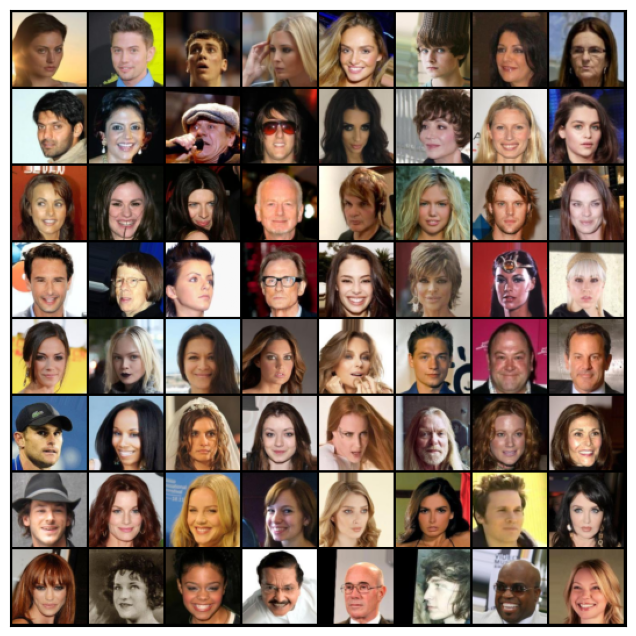

In [8]:
show_batch(train_dl)

## Using a GPU

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    """ 3 things:
    1. Connected to Nvidia GPU
    2. Cuda drivers
    3. Pytorch suitable to GPU version
    then torch.cuda.is_available is True
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

## Build GAN

### Discriminator Network

In [12]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
discriminator = to_device(discriminator, device)

### printing the output shape after each layer of discrminator.

In [14]:
# create a tensor Batch_Size,C,H,W
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
LeakyReLU output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
LeakyReLU output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
LeakyReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
LeakyReLU output shape: 	 torch.Size([1, 512, 4, 4])
Conv2d output shape: 	 torch.Size([1, 1, 1, 1])
Flatten output shape: 	 torch.Size([1, 1])
Sigmoid output shape: 	 torch.Size([1, 1])


# Generator Network

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

### output shaper for the generator 

In [17]:
X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


#### testing the fake images

torch.Size([128, 3, 64, 64])


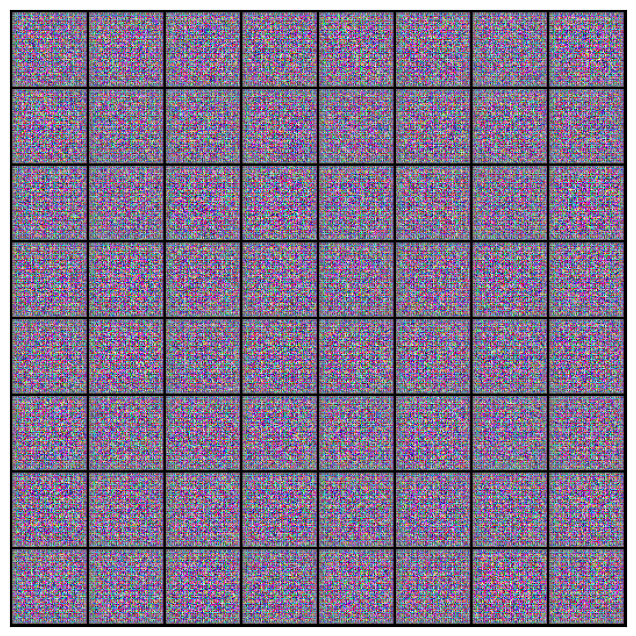

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [19]:
generator = to_device(generator, device) # move generator to device

## Training Discriminator

In [20]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through  discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass Fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score



## Training the Discriminator

The training of the discriminator involves several key steps to enhance its ability to distinguish between real and generated images. Below are the sequential steps performed during the training process:

1. **Discriminator Output Expectations:**
   - The discriminator is designed to output 1 if the input image is from the real Anime Faces dataset and 0 if it was generated by the generator network.

2. **Real Image Batch:**
   - A batch of real images is passed through the discriminator.
   - The loss is computed with the target labels set to 1, indicating that these images are authentic.

3. **Fake Image Batch (Generator Output):**
   - A batch of fake images generated by the generator is passed through the discriminator.
   - The loss is computed with the target labels set to 0, indicating that these images are synthetic.

4. **Loss Computation and Gradient Descent:**
   - The losses from the real and fake image batches are summed to obtain the overall loss.
   - Gradient descent is then performed to adjust the weights of the discriminator based on the calculated loss.

It is crucial to emphasize that during the training of the discriminator, the weights of the generator model remain unchanged. The optimization process, specifically `opt_d`, exclusively influences the parameters of the discriminator, ensuring a focused improvement in its discriminatory capabilities without altering the generator's weights.


## Generator Training

The training of the generator involves the following key steps to improve its ability to generate realistic images that can deceive the discriminator:

1. **Generate Batch of Images:**
   - A batch of synthetic images is generated using the generator.

2. **Discriminator Evaluation:**
   - The generated images are passed through the discriminator.

3. **Loss Computation:**
   - The loss is calculated by setting the target labels to 1 (indicating real images). This approach is taken because the primary goal of the generator is to "fool" the discriminator into classifying its generated images as real.

4. **Gradient Descent and Weight Adjustment:**
   - The calculated loss is utilized to perform gradient descent.
   - The weights of the generator are adjusted during this process, aiming to enhance its capability to generate images that closely resemble real ones and thereby deceive the discriminator.

By iteratively optimizing the generator based on its ability to "fool" the discriminator, we aim to achieve a generator that produces increasingly realistic and convincing synthetic images.


In [21]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator 
  loss.backward()
  opt_g.step()

  return loss.item()

### Creating a directory for intermediate outputs

In [22]:
from torchvision.utils import save_image


In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated=images-0000.png


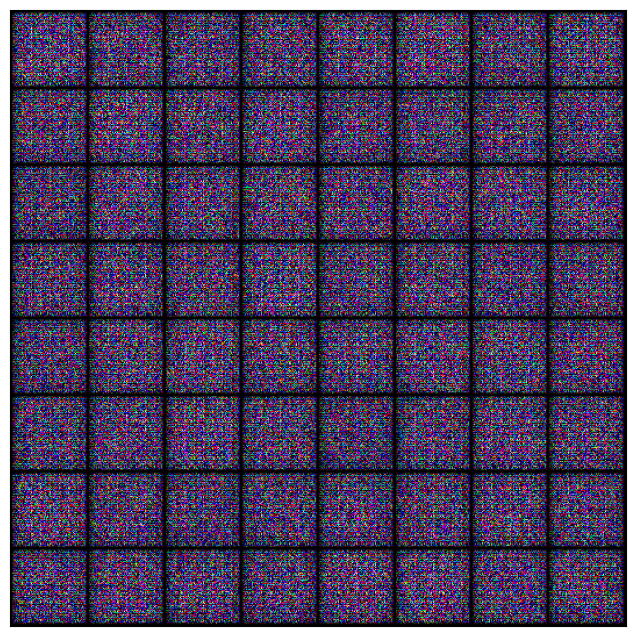

In [26]:
save_samples(0, fixed_latent)

## Training Loop

In [27]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [28]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # Train generator
      loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [29]:
# Hyperparameters
lr = 0.00025
epochs = 60

In [30]:
history = fit(epochs, lr)

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 4.0992, loss_d: 0.4222, real_score: 0.9247, fake_score: 0.2571
Saving generated=images-0001.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 4.5617, loss_d: 0.4986, real_score: 0.9766, fake_score: 0.3241
Saving generated=images-0002.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 6.0698, loss_d: 0.8866, real_score: 0.9711, fake_score: 0.5210
Saving generated=images-0003.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 3.2440, loss_d: 0.4618, real_score: 0.9197, fake_score: 0.2846
Saving generated=images-0004.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 3.7002, loss_d: 0.8572, real_score: 0.9898, fake_score: 0.4976
Saving generated=images-0005.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 3.2325, loss_d: 0.1369, real_score: 0.9294, fake_score: 0.0566
Saving generated=images-0006.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 3.7446, loss_d: 0.0844, real_score: 0.9738, fake_score: 0.0533
Saving generated=images-0007.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 4.9110, loss_d: 0.0414, real_score: 0.9673, fake_score: 0.0066
Saving generated=images-0008.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 5.7868, loss_d: 0.2943, real_score: 0.9722, fake_score: 0.2098
Saving generated=images-0009.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 4.0888, loss_d: 0.5752, real_score: 0.9354, fake_score: 0.3412
Saving generated=images-0010.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 4.7791, loss_d: 0.6202, real_score: 0.9679, fake_score: 0.3829
Saving generated=images-0011.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 3.9477, loss_d: 0.1729, real_score: 0.8854, fake_score: 0.0294
Saving generated=images-0012.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 2.6537, loss_d: 0.4463, real_score: 0.7712, fake_score: 0.0919
Saving generated=images-0013.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 6.2471, loss_d: 0.9373, real_score: 0.9785, fake_score: 0.4966
Saving generated=images-0014.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 5.3233, loss_d: 0.0431, real_score: 0.9783, fake_score: 0.0197
Saving generated=images-0015.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 3.9751, loss_d: 0.1193, real_score: 0.9067, fake_score: 0.0075
Saving generated=images-0016.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 4.4684, loss_d: 0.0871, real_score: 0.9671, fake_score: 0.0486
Saving generated=images-0017.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 1.3177, loss_d: 0.4636, real_score: 0.7168, fake_score: 0.0101
Saving generated=images-0018.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 3.8617, loss_d: 0.1062, real_score: 0.9409, fake_score: 0.0353
Saving generated=images-0019.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 5.5630, loss_d: 0.0968, real_score: 0.9709, fake_score: 0.0588
Saving generated=images-0020.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 4.8555, loss_d: 0.1303, real_score: 0.9391, fake_score: 0.0547
Saving generated=images-0021.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 3.1958, loss_d: 0.3148, real_score: 0.9250, fake_score: 0.1697
Saving generated=images-0022.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 3.9521, loss_d: 0.3041, real_score: 0.7807, fake_score: 0.0048
Saving generated=images-0023.png


  0%|          | 0/1583 [00:00<?, ?it/s]

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.



In [2]:
from IPython.display import Image


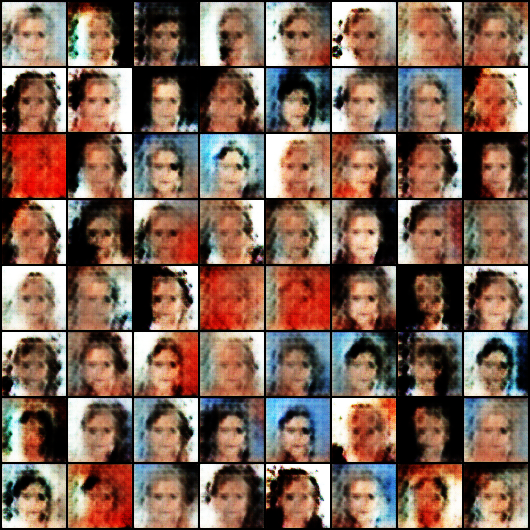

In [4]:
Image('./generated/generated=images-0001.png')


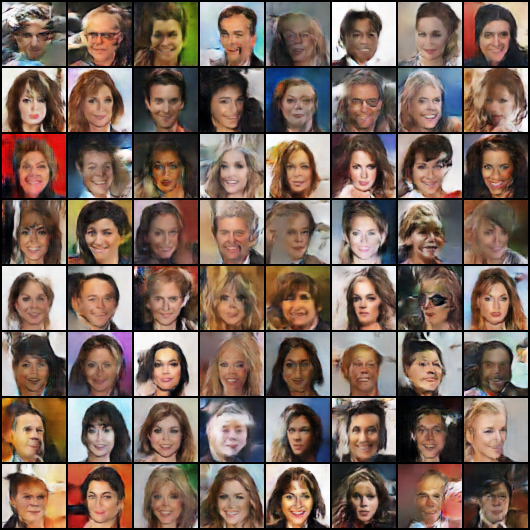

In [5]:
Image('./generated/generated=images-0005.png')


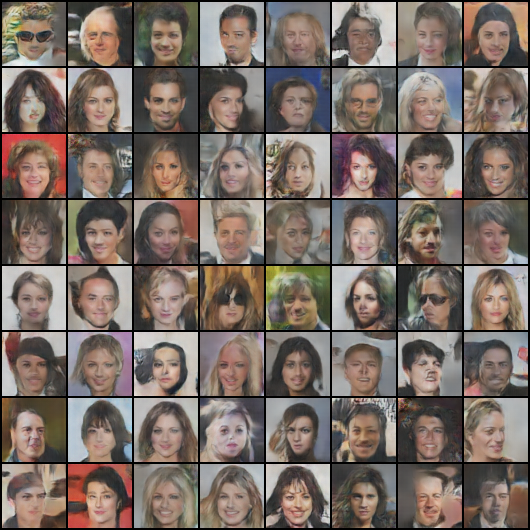

In [6]:
Image('./generated/generated=images-0010.png')


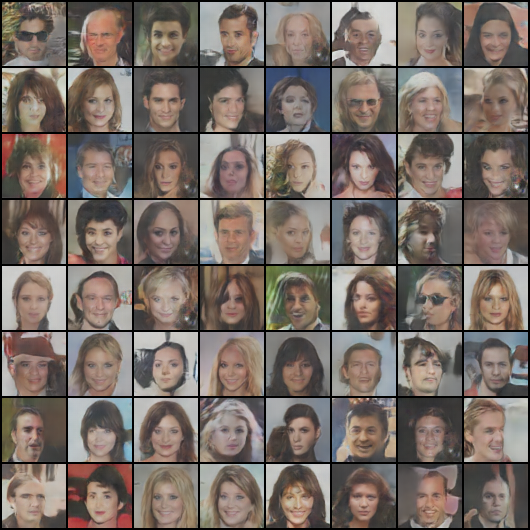

In [7]:
Image('./generated/generated=images-0020.png')


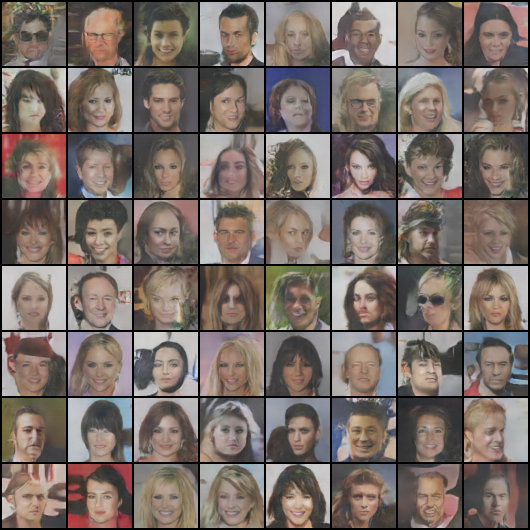

In [9]:
Image('./generated/generated=images-0025.png')


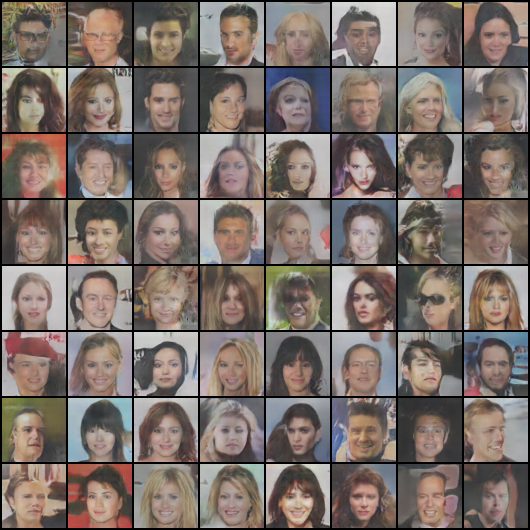

In [10]:
Image('./generated/generated=images-0030.png')

In [ ]:
Image('./generated/generated=images-0035.png')

In [ ]:
Image('./generated/generated=images-0040.png')

In [ ]:
Image('./generated/generated=images-0045.png')

In [ ]:
Image('./generated/generated=images-0050.png')

In [ ]:
Image('./generated/generated=images-0055.png')

In [ ]:
Image('./generated/generated=images-0060.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

print("Starting converting images to video.")
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

print(files)

fourcc = cv2.VideoWriter_fourcc(*'MPEG')
out = cv2.VideoWriter(vid_fname,fourcc, 1.0, (640,480))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
print("DONE!")

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');